# Decision Transformer with Offline RL
This approach reframes reinforcement learning as a sequence modeling problem by conditioning on future rewards. Key modifications include:

- **Return-to-Go Representation**: Instead of feeding raw rewards, the model is conditioned on return-to-go values.

- **Offline Dataset**: Training is conducted on a pre-collected dataset without active environment interaction.

- **Causally Masked Transformer**: A Transformer architecture is employed with causal masking to ensure autoregressive learning.

This setup enables learning optimal policies from offline data while leveraging the power of sequence modeling.

DQN Epoch 1/20 | Total Reward: 43.71 | Epsilon: 0.950
DQN Epoch 2/20 | Total Reward: 62.09 | Epsilon: 0.902
DQN Epoch 3/20 | Total Reward: 106.47 | Epsilon: 0.857
DQN Epoch 4/20 | Total Reward: 90.95 | Epsilon: 0.815
DQN Epoch 5/20 | Total Reward: 96.53 | Epsilon: 0.774
DQN Epoch 6/20 | Total Reward: 131.90 | Epsilon: 0.735
DQN Epoch 7/20 | Total Reward: 152.05 | Epsilon: 0.698
DQN Epoch 8/20 | Total Reward: 137.58 | Epsilon: 0.663
DQN Epoch 9/20 | Total Reward: 184.18 | Epsilon: 0.630
DQN Epoch 10/20 | Total Reward: 163.94 | Epsilon: 0.599
DQN Epoch 11/20 | Total Reward: 210.71 | Epsilon: 0.569
DQN Epoch 12/20 | Total Reward: 202.89 | Epsilon: 0.540
DQN Epoch 13/20 | Total Reward: 202.65 | Epsilon: 0.513
DQN Epoch 14/20 | Total Reward: 256.82 | Epsilon: 0.488
DQN Epoch 15/20 | Total Reward: 258.36 | Epsilon: 0.463
DQN Epoch 16/20 | Total Reward: 288.47 | Epsilon: 0.440
DQN Epoch 17/20 | Total Reward: 282.61 | Epsilon: 0.418
DQN Epoch 18/20 | Total Reward: 296.13 | Epsilon: 0.397
DQN E

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


DT Epoch 1/10 | Loss: 1.0876
DT Epoch 2/10 | Loss: 1.0853
DT Epoch 3/10 | Loss: 1.0833
DT Epoch 4/10 | Loss: 1.0802
DT Epoch 5/10 | Loss: 1.0767
DT Epoch 6/10 | Loss: 1.0729
DT Epoch 7/10 | Loss: 1.0690
DT Epoch 8/10 | Loss: 1.0641
DT Epoch 9/10 | Loss: 1.0587
DT Epoch 10/10 | Loss: 1.0530
Total Reward DT: 140.67794287537606
Total Reward DQN: 177.84600665978556


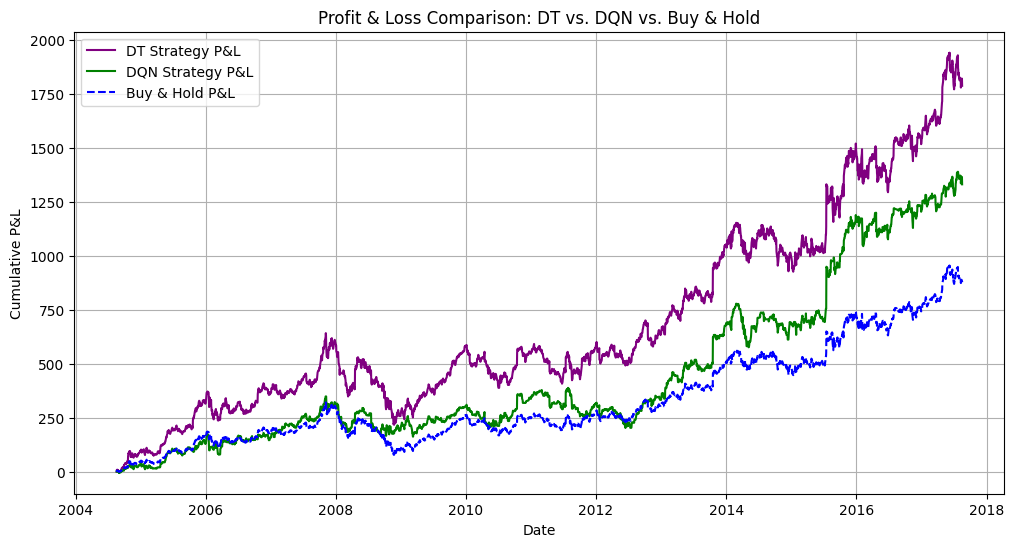

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader


# Data Preprocessing

def compute_macd_rsi(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    data.fillna(0, inplace=True)
    return data

def compute_returns(data):
    vol = data['Close'].pct_change().rolling(60).std()
    data['MonthlyReturn'] = (data['Close'].pct_change(21) / (vol * np.sqrt(21))).fillna(0)
    data['BiMonthlyReturn'] = (data['Close'].pct_change(42) / (vol * np.sqrt(42))).fillna(0)
    data['QuarterlyReturn'] = (data['Close'].pct_change(63) / (vol * np.sqrt(63))).fillna(0)
    data['AnnualReturn'] = (data['Close'].pct_change(252) / (vol * np.sqrt(252))).fillna(0)
    return data

def preprocess_data(data):
    data['Close_Norm'] = data['Close'] / data['Close'].max()
    data = compute_macd_rsi(data)
    data = compute_returns(data)
    return data

def ewma_std(prices, window=60):
    return prices.ewm(span=window).std()

def get_state(data, t):
    # Ensure we have at least 60 time steps.
    if t < 60:
        return None
    return np.concatenate([
        data['Close_Norm'].values[t-60:t],
        data['MonthlyReturn'].values[t-60:t],
        data['BiMonthlyReturn'].values[t-60:t],
        data['QuarterlyReturn'].values[t-60:t],
        data['AnnualReturn'].values[t-60:t],
        data['MACD'].values[t-60:t],
        data['RSI'].values[t-60:t]
    ])


# DQN Agent and Training

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ExperienceReplay:
    def __init__(self, capacity=10000):
        self.memory = []
        self.capacity = capacity

    def push(self, state, action, reward, next_state):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def calculate_reward(pt, pt_1, pt_2, At_1, At_2, sigma_t, sigma_t_1, sigma_t_2, sigma_tgt=1, C=0.0001, mu=1):
    rt = pt - pt_1
    term1 = (sigma_tgt / sigma_t_1) * At_1 * rt
    term2 = -C * pt_1
    term3 = (sigma_tgt / sigma_t_1) * At_1 - (sigma_tgt / sigma_t_2) * At_2
    return mu * (term1 + (term2 * abs(term3)))

def train_dqn(data, agent, replay_buffer, optimizer, epochs=10, batch_size=256, gamma=0.99,
              sigma_tgt=1, cost_rate=0.0001, epsilon_start=1.0, epsilon_end=0.01,
              epsilon_decay=0.995, target_update_freq=500):
    prices = data['Close'].values
    sigma = ewma_std(pd.Series(prices), window=60).values
    sigma[np.isnan(sigma)] = sigma_tgt

    # Initialize target network
    target_agent = DQN(agent.state_dim, agent.action_dim)
    target_agent.load_state_dict(agent.state_dict())
    target_agent.eval()

    loss_fn = nn.MSELoss()
    step_counter = 0
    epsilon = epsilon_start

    # To build an offline dataset, we store full episodes.
    episodes_states = []  # list of episodes (each is a list of states)
    episodes_actions = []  # list of episodes actions
    episodes_rewards = []  # list of episodes immediate rewards

    # For simplicity, treat one epoch as one episode.
    for epoch in range(epochs):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        pt_1, pt_2 = prices[0], prices[0]
        At_1, At_2 = 0, 0
        total_reward = 0

        # We start from t=60 so that get_state is valid.
        for t in range(60, len(prices)):
            state = get_state(data, t-1)
            if state is None:
                continue
            ep_states.append(state)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randint(0, agent.action_dim - 1)
            else:
                with torch.no_grad():
                    q_values = agent(state_tensor)
                action = torch.argmax(q_values).item()

            # Compute reward
            reward = calculate_reward(
                pt=prices[t], pt_1=pt_1, pt_2=pt_2,
                At_1=action, At_2=At_2,
                sigma_t=sigma[t], sigma_t_1=sigma[t-1], sigma_t_2=sigma[t-2],
                sigma_tgt=sigma_tgt, C=cost_rate
            )
            ep_rewards.append(reward)
            total_reward += reward
            ep_actions.append(action)

            # Store transition in replay buffer (for DQN training)
            next_state = get_state(data, t)
            if next_state is not None:
                replay_buffer.push(state, action, reward, next_state)

            # Update tracking variables
            pt_2, pt_1 = pt_1, prices[t]
            At_2, At_1 = At_1, action

            # Train with batches from replay buffer
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states = torch.tensor(np.array(states), dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32)

                q_values = agent(states).gather(1, actions.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    next_q_values = target_agent(next_states).max(1)[0]
                targets = rewards + gamma * next_q_values

                loss = loss_fn(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                step_counter += 1

                if step_counter % target_update_freq == 0:
                    target_agent.load_state_dict(agent.state_dict())

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        print(f"DQN Epoch {epoch+1}/{epochs} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")
        episodes_states.append(ep_states)
        episodes_actions.append(ep_actions)
        episodes_rewards.append(ep_rewards)
    return episodes_states, episodes_actions, episodes_rewards


# Decision Transformer (DT)

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, action_dim, d_model=128, n_layers=2, n_heads=4, context_len=10, dropout=0.1):
        super(DecisionTransformer, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.context_len = context_len
        self.d_model = d_model

        # Embedding layers for state and return-to-go (rtg)
        self.state_embed = nn.Linear(state_dim, d_model)
        self.rtg_embed = nn.Linear(1, d_model)
        # For actions, we use an embedding (plus a projection head later)
        self.action_embed = nn.Embedding(action_dim, d_model)

        # Positional embedding for sequence tokens (we have triplets per time step)
        self.pos_embed = nn.Parameter(torch.zeros(context_len, d_model))

        # Transformer encoder with causal mask
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Final head to predict actions (logits)
        self.action_head = nn.Linear(d_model, action_dim)

    def forward(self, states, rtgs, actions=None):
        # states: (batch, seq_len, state_dim)
        # rtgs: (batch, seq_len, 1)
        # actions: (batch, seq_len) OPTIONAL (for teacher forcing)
        # Embed states and rtgs
        bs, seq_len, _ = states.shape
        state_embeddings = self.state_embed(states)  # (bs, seq_len, d_model)
        rtg_embeddings = self.rtg_embed(rtgs)          # (bs, seq_len, d_model)

        # If actions are provided (during training) embed them; otherwise use zeros.
        if actions is not None:
            action_embeddings = self.action_embed(actions)  # (bs, seq_len, d_model)
        else:
            action_embeddings = torch.zeros(bs, seq_len, self.d_model, device=states.device)

        # For simplicity, here we combine modalities by summing state and rtg embeddings (you could also concatenate)
        x = state_embeddings + rtg_embeddings + self.pos_embed[:seq_len, :]

        # Permute for transformer: (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        # Create causal mask (subsequent positions masked)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device) * float('-inf'), diagonal=1)
        x = self.transformer(x, mask=mask)
        # Permute back: (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)

        # Predict actions (for each time step)
        logits = self.action_head(x)  # (bs, seq_len, action_dim)
        return logits


# Offline Dataset for DT

class OfflineDataset(Dataset):
    def __init__(self, episodes, context_len=10):
        """
        episodes: list of tuples (states, actions, rewards) where
          states is a list of state vectors,
          actions is a list of integers,
          rewards is a list of immediate rewards.
        For each episode we compute returns-to-go (rtg) at each time step.
        We then form sequences (of length context_len) using a sliding window.
        """
        self.context_len = context_len
        self.samples = []
        for ep_states, ep_actions, ep_rewards in episodes:
            T = len(ep_states)
            if T < context_len:
                continue
            # Compute return-to-go for each time step (backwards cumulative sum)
            rtg = np.zeros(T)
            future_return = 0
            for t in reversed(range(T)):
                future_return += ep_rewards[t]
                rtg[t] = future_return
            # Build sliding windows
            for t in range(T - context_len + 1):
                states_seq = np.array(ep_states[t:t+context_len])  # (context_len, state_dim)
                actions_seq = np.array(ep_actions[t:t+context_len])  # (context_len,)
                rtg_seq = np.array(rtg[t:t+context_len]).reshape(-1, 1)  # (context_len, 1)
                self.samples.append((states_seq, rtg_seq, actions_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        states_seq, rtg_seq, actions_seq = self.samples[idx]
        return torch.tensor(states_seq, dtype=torch.float32), \
               torch.tensor(rtg_seq, dtype=torch.float32), \
               torch.tensor(actions_seq, dtype=torch.long)


# Training DT

def train_dt(dt_model, offline_dataset, epochs=10, batch_size=32, lr=1e-4):
    dataloader = DataLoader(offline_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(dt_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    dt_model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for states_seq, rtg_seq, actions_seq in dataloader:
            # Forward pass: predict logits for actions
            logits = dt_model(states_seq, rtg_seq)  # (batch, seq_len, action_dim)
            # Compute loss: reshape to (batch*seq_len, action_dim)
            loss = loss_fn(logits.view(-1, dt_model.action_dim), actions_seq.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"DT Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f}")


# Evaluate DT (simulate decision making)

def evaluate_dt(dt_model, data, context_len=10, init_rtg=10):
    dt_model.eval()
    prices = data['Close'].values
    total_reward = 0
    decisions = []
    rtg = init_rtg
    trajectory_states = []   # list of states used in context
    trajectory_rtgs = []     # corresponding rtg values

    pt_1, pt_2 = prices[0], prices[0]
    At_1, At_2 = 0, 0
    sigma = ewma_std(pd.Series(prices), window=60).values
    sigma[np.isnan(sigma)] = 1

    # For each time step, use the most recent context (pad if needed)
    for t in range(60, len(prices)):
        state = get_state(data, t-1)
        if state is None:
            continue
        trajectory_states.append(state)
        trajectory_rtgs.append([rtg])
        # Prepare input context: if trajectory is shorter than context_len, pad at beginning
        cur_len = len(trajectory_states)
        if cur_len < context_len:
            pad_len = context_len - cur_len
            pad_states = [np.zeros_like(state)] * pad_len
            pad_rtgs = [[0]] * pad_len
            input_states = np.array(pad_states + trajectory_states)
            input_rtgs = np.array(pad_rtgs + trajectory_rtgs)
        else:
            input_states = np.array(trajectory_states[-context_len:])
            input_rtgs = np.array(trajectory_rtgs[-context_len:])
        input_states = torch.tensor(input_states, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, state_dim)
        input_rtgs = torch.tensor(input_rtgs, dtype=torch.float32).unsqueeze(0)      # (1, seq_len, 1)
        with torch.no_grad():
            logits = dt_model(input_states, input_rtgs)  # (1, seq_len, action_dim)
        # Use the prediction from the last token in the sequence
        action = torch.argmax(logits[0, -1]).item()
        decisions.append(action)
        # Compute reward
        reward = calculate_reward(
            pt=prices[t], pt_1=pt_1, pt_2=pt_2,
            At_1=action, At_2=At_2,
            sigma_t=sigma[t], sigma_t_1=sigma[t-1], sigma_t_2=sigma[t-2]
        )
        total_reward += reward
        # Update return-to-go (decrease by obtained reward)
        rtg = rtg - reward
        # Update tracking
        pt_2, pt_1 = pt_1, prices[t]
        At_2, At_1 = At_1, action

    return total_reward, decisions


# Evaluate DQN (using final epoch decisions)

def evaluate_dqn(data, decisions):
    prices = data['Close'].values
    total_reward = 0
    pt_1, pt_2 = prices[0], prices[0]
    sigma = ewma_std(pd.Series(prices), window=60).values
    sigma[np.isnan(sigma)] = 1
    for t, action in enumerate(decisions, start=60):
        reward = calculate_reward(
            pt=prices[t], pt_1=pt_1, pt_2=pt_2,
            At_1=action, At_2=0,  # For simplicity, we do not track two previous actions here.
            sigma_t=sigma[t], sigma_t_1=sigma[t-1], sigma_t_2=sigma[t-2]
        )
        total_reward += reward
        pt_2, pt_1 = pt_1, prices[t]
    return total_reward


# P&L Comparison Plotting

def plot_pnl_comparison_updated(data, dt_decisions, dqn_decisions):
    prices = data['Close'].values
    dates = data.index
    def compute_pnl(decisions):
        decisions = np.array(decisions)
        min_length = min(len(prices) - 1, len(decisions))
        pnl = np.cumsum(np.diff(prices[:min_length+1]) * decisions[:min_length])
        return np.insert(pnl, 0, 0)
    pnl_dqn = compute_pnl(dqn_decisions)
    pnl_dt = compute_pnl(dt_decisions)
    pnl_buy_hold = prices[:len(pnl_dqn)] - prices[0]

    plt.figure(figsize=(12, 6))
    plt.plot(dates[:len(pnl_dt)], pnl_dt, label="DT Strategy P&L", color="purple")
    plt.plot(dates[:len(pnl_dqn)], pnl_dqn, label="DQN Strategy P&L", color="green")
    plt.plot(dates[:len(pnl_buy_hold)], pnl_buy_hold, label="Buy & Hold P&L", color="blue", linestyle="dashed")
    plt.title("Profit & Loss Comparison: DT vs. DQN vs. Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative P&L")
    plt.legend()
    plt.grid(True)
    plt.show()


# Main Execution

if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('googl.us.txt', parse_dates=['Date'], index_col='Date')
    data = preprocess_data(data)

    # DQN settings
    state_dim = 60 * 7  # 60 timesteps for 7 features
    action_dim = 3      # 0: Hold, 1: Buy, 2: Sell
    agent = DQN(state_dim, action_dim)
    optimizer = optim.Adam(agent.parameters(), lr=0.0005)
    replay_buffer = ExperienceReplay(capacity=10000)

    # Train DQN (with fewer epochs initially) and record episodes offline
    episodes_states, episodes_actions, episodes_rewards = train_dqn(
        data, agent, replay_buffer, optimizer,
        epochs=20, batch_size=256, target_update_freq=500, gamma=0.99, epsilon_decay=0.95
    )
    # For evaluation, we use the decisions from the last DQN epoch
    dqn_decisions = episodes_actions[-1]
    dqn_total_reward = evaluate_dqn(data, dqn_decisions)

    
    # Prepare Offline Dataset for DT
    
    # Each episode is a tuple (states, actions, rewards)
    episodes = []
    for s_list, a_list, r_list in zip(episodes_states, episodes_actions, episodes_rewards):
        # Only include episodes with at least one sample
        if len(s_list) >= 10:
            episodes.append((s_list, a_list, r_list))
    context_len = 10
    offline_dataset = OfflineDataset(episodes, context_len=context_len)
    # Set expert initial return-to-go to be higher than the max episode return in offline data
    max_return = max([sum(r_list) for (_, _, r_list) in episodes]) if episodes else 1
    expert_rtg = max_return * 1.5

    
    # Initialize and Train Decision Transformer
    
    dt_model = DecisionTransformer(state_dim, action_dim, d_model=128, n_layers=2, n_heads=4, context_len=context_len)
    train_dt(dt_model, offline_dataset, epochs=10, batch_size=32, lr=1e-4)

    
    # Evaluate Decision Transformer
    
    dt_total_reward, dt_decisions = evaluate_dt(dt_model, data, context_len=context_len, init_rtg=expert_rtg)

    print("Total Reward DT:", dt_total_reward)
    print("Total Reward DQN:", dqn_total_reward)

    
    # Plot P&L Comparison
    
    plot_pnl_comparison_updated(data, dt_decisions, dqn_decisions)